In [1]:
import pandas as pd
import os
import copy as cp
from copy import deepcopy
import numpy as np

#### Import and clean county to DOE CZ crosswalk

In [2]:
path_czc = "/Users/rose775/Library/CloudStorage/OneDrive-PNNL/Desktop/Projects/randoms/county_to_doecz.csv"
df_czc = pd.read_csv(path_czc) 
df_czc.head()

,Unnamed: 0,State,County,BA Climate Zone,old,new,IECC 2021 Climate Zone (1-8),oldm,newm,IECC 2021 Moisture Regime,cz
0,AL,Alabama,Autauga,Hot-Humid,3,NaN,3,A,NaN,A,3A
1,AL,Alabama,Baldwin,Hot-Humid,2,NaN,2,A,NaN,A,2A
2,AL,Alabama,Barbour,Hot-Humid,3,NaN,3,A,NaN,A,3A
3,AL,Alabama,Bibb,Mixed-Humid,3,NaN,3,A,NaN,A,3A
4,AL,Alabama,Blount,Mixed-Humid,3,NaN,3,A,NaN,A,3A


#### Import and clean EPA AQ data

In [3]:
# EPA PM2.5 FRM/FEM Mass (88101)
path_aq = "/Users/rose775/Library/CloudStorage/OneDrive-PNNL/Desktop/Projects/NEI/daily_88101_2023.csv"
df_aq = pd.read_csv(path_aq)
df_aq["Date Local"] = pd.to_datetime(df_aq["Date Local"])
df_aq.head(1)
print(len(df_aq))

351816


   site_num first_date  last_date  num_days     state   county
0         1 2023-01-01 2023-09-30       273   Alabama     Clay
1         2 2023-01-01 2023-09-30       273  Arkansas     Polk
2         3 2023-01-01 2023-09-30       273   Alabama   Mobile
3         4 2023-01-01 2023-09-30       273    Alaska  Juneau 
4         5 2023-01-01 2023-09-30       273  Arkansas   Ashley


Total number of sites = 259


Min days for any site = 31


Number of sites with data from less than 175 days = 9


<Axes: >

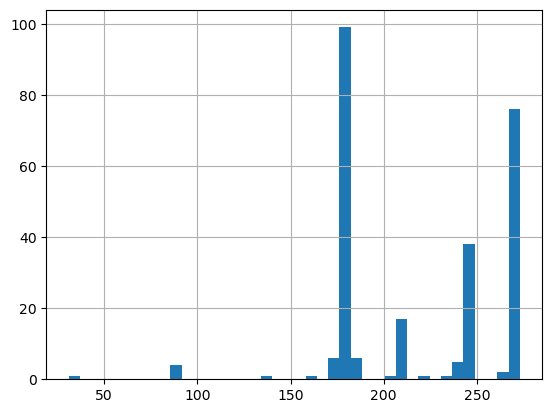

In [4]:
aq_site_date_range = df_aq.groupby("Site Num").agg(first_date=("Date Local", "min"),
                                         last_date=("Date Local", "max"),
                                         num_days=("Date Local", lambda x: (x.max() - x.min()).days + 1),
                                         state = ("State Name", "first"),
                                         county = ("County Name", "first")
).reset_index()
aq_site_date_range.columns = ["site_num", "first_date", "last_date", "num_days", "state", "county"]
print(aq_site_date_range.head())
print("\n")
print(f"Total number of sites = {len(aq_site_date_range)}")
print("\n")
print(f"Min days for any site = {min(aq_site_date_range['num_days'])}")
print("\n")
print(f"Number of sites with data from less than 175 days = {sum(aq_site_date_range['num_days'] < 175)}")
aq_site_date_range["num_days"].hist(bins = 40)

In [5]:
# drop rows with < 175 days
sites_to_exclude = aq_site_date_range.loc[aq_site_date_range["num_days"] < 175, "site_num"]
df_aq_slim = df_aq[~df_aq["Site Num"].isin(sites_to_exclude)]

# drop rows where obvservation_count (number of hours in each day where observation occurred) < 10
df_aq_slim[df_aq_slim["Observation Percent"] > 25]

df_aq_slim.head(1)
print(len(df_aq_slim))

350527


In [6]:
# aggregate pollutant by county
df_aq_out = df_aq_slim.groupby(["State Name", "County Name", "State Code", "County Code"]).agg({"Arithmetic Mean" : "mean"}).reset_index()
print(df_aq_out.head())
print(f"There are {len(df_aq_out)} rows")

  State Name County Name  State Code  County Code  Arithmetic Mean
0    Alabama     Baldwin           1            3         7.712846
1    Alabama        Clay           1           27        10.461391
2    Alabama      DeKalb           1           49         9.537822
3    Alabama      Etowah           1           55         9.690845
4    Alabama   Jefferson           1           73         9.978463
There are 608 rows


#### Merge pollutant data with climate zone

In [7]:
aq_cz_merged = pd.merge(df_aq_out, df_czc, left_on = ["State Name", "County Name"], right_on = ["State", "County"])[["State Name", "State Code", "County Name", "County Code", "Arithmetic Mean", "BA Climate Zone"]]
aq_cz_merged.head()

,State Name,State Code,County Name,County Code,Arithmetic Mean,BA Climate Zone
0,Alabama,1,Baldwin,3,7.712846,Hot-Humid
1,Alabama,1,Clay,27,10.461391,Mixed-Humid
2,Alabama,1,DeKalb,49,9.537822,Mixed-Humid
3,Alabama,1,Etowah,55,9.690845,Mixed-Humid
4,Alabama,1,Jefferson,73,9.978463,Mixed-Humid


In [8]:
print(f"There are {len(aq_cz_merged['BA Climate Zone'].unique())} unique BA Climate Zones represented")

There are 11 unique BA Climate Zones represented


#### Build infiltration assumption table

In [9]:
infiltration = {
    "Total": {"inf_rcs_med" : 0.25, "inf_rcs_mean" : 0.28, "inf_trad_med" : 0.26, "inf_trad_mean" : 0.29},
    "Marine": {"inf_rcs_med" : 0.27, "inf_rcs_mean" : 0.29, "inf_trad_med" : 0.27, "inf_trad_mean" : 0.29},
    "Hot Dry": {"inf_rcs_med" : 0.22, "inf_rcs_mean" : 0.26, "inf_trad_med" : 0.23, "inf_trad_mean" : 0.26},
    "Cold": {"inf_rcs_med" : 0.22, "inf_rcs_mean" : 0.27, "inf_trad_med" : 0.21, "inf_trad_mean" : 0.27},
    "Other": {"inf_rcs_med" : 0.24, "inf_rcs_mean" : 0.28, "inf_trad_med" : 0.24, "inf_trad_mean" : 0.33},
}

#### Analysis

In [10]:
print(aq_cz_merged["BA Climate Zone"].unique())

['Hot-Humid' 'Mixed-Humid' 'Cold' 'Hot-Dry' 'Marine' 'Mixed-Dry'
 'Cold→Mixed-Humid' 'Hot-humid' 'Very Cold' 'Very Cold→Cold'
 'Cold→Mixed-Dry']


In [11]:
# true bins
total = ["Hot-Humid", "Mixed-Humid", "Mixed-Dry","Cold→Mixed-Humid",
         "Hot-humid", "Very Cold", "Very Cold→Cold","Cold→Mixed-Dry",
         "Marine", "Hot-Dry", "Cold"]
marine = ["Marine"]
hot_dry = ["Hot-Dry"]
cold = ["Cold"]
other = ["Hot-Humid", "Mixed-Humid", "Mixed-Dry","Cold→Mixed-Humid",
         "Hot-humid", "Very Cold", "Very Cold→Cold","Cold→Mixed-Dry"]

# reasonable bins
cold_2 = ["Cold", "Cold→Mixed-Humid", "Very Cold", "Very Cold→Cold", "Cold→Mixed-Dry"]


In [12]:
def append_simple_cz(row):
    if row["BA Climate Zone"] in total:
        zone = "Total"
    elif row["BA Climate Zone"] in marine:
        zone = "Marine"
    elif row["BA Climate Zone"] in hot_dry:
        zone = "Hot Dry"
    elif row["BA Climate Zone"] in cold:
        zone = "Cold"
    else:
        zone = "Other"
    return zone

In [13]:
aq_cz_merged["simple_cz"] = aq_cz_merged.apply(append_simple_cz, axis=1)

In [14]:
def calculate_infiltration(row):
    if row["BA Climate Zone"] in total:
        zone = "Total"
    elif row["BA Climate Zone"] in marine:
        zone = "Marine"
    elif row["BA Climate Zone"] in hot_dry:
        zone = "Hot Dry"
    elif row["BA Climate Zone"] in cold:
        zone = "Cold"
    else:
        zone = "Other"
    return row["Arithmetic Mean"] * infiltration[zone]["inf_rcs_mean"]

In [15]:
aq_cz_merged["inf_rcs_mean"] = aq_cz_merged.apply(calculate_infiltration, axis=1)
aq_cz_merged["assumed_indoor_conc"] = aq_cz_merged["inf_rcs_mean"] / 0.61
aq_cz_merged


,State Name,State Code,County Name,County Code,Arithmetic Mean,BA Climate Zone,simple_cz,inf_rcs_mean,assumed_indoor_conc
0,Alabama,1,Baldwin,3,7.712846,Hot-Humid,Total,2.159597,3.540323
1,Alabama,1,Clay,27,10.461391,Mixed-Humid,Total,2.929190,4.801950
2,Alabama,1,DeKalb,49,9.537822,Mixed-Humid,Total,2.670590,4.378017
3,Alabama,1,Etowah,55,9.690845,Mixed-Humid,Total,2.713437,4.448257
4,Alabama,1,Jefferson,73,9.978463,Mixed-Humid,Total,2.793970,4.580278
...,...,...,...,...,...,...,...,...,...
577,Wyoming,56,Park,29,3.484657,Cold,Total,0.975704,1.599515
578,Wyoming,56,Sheridan,33,8.648185,Cold,Total,2.421492,3.969659
579,Wyoming,56,Sublette,35,3.968453,Very Cold,Total,1.111167,1.821585
580,Wyoming,56,Sweetwater,37,4.520218,Cold,Total,1.265661,2.074854


In [16]:
# goal is to multiply by a point on the distribution rather than just the median. this currently is not doing that
percentiles = [0.1, 0.5, 0.9]
infiltration_factors = {
    "Total": [0.08, 0.25, 0.52],
    "Marine": [0.09, 0.27, 0.51],
    "Hot Dry": [0.07, 0.22, 0.49],
    "Cold": [0.06, 0.22, 0.56],
    "Other": [0.06, 0.24, 0.55],
}

# Apply the infiltration factors based on group
for group, factors in infiltration_factors.items():
    group_mask = aq_cz_merged["simple_cz"] == group
    num_samples = sum(group_mask)  # Number of samples to draw
    random_indices = np.random.choice(len(factors), size=num_samples)
    random_values = [factors[idx] for idx in random_indices]
    aq_cz_merged.loc[group_mask, "inf_rcs_mean_dist"] = aq_cz_merged.loc[group_mask, "Arithmetic Mean"] * random_values

aq_cz_merged["assumed_indoor_conc_dist"] = aq_cz_merged["inf_rcs_mean_dist"] / 0.61


In [17]:
aq_cz_merged

,State Name,State Code,County Name,County Code,Arithmetic Mean,BA Climate Zone,simple_cz,inf_rcs_mean,assumed_indoor_conc,inf_rcs_mean_dist,assumed_indoor_conc_dist
0,Alabama,1,Baldwin,3,7.712846,Hot-Humid,Total,2.159597,3.540323,1.928212,3.161003
1,Alabama,1,Clay,27,10.461391,Mixed-Humid,Total,2.929190,4.801950,5.439923,8.917907
2,Alabama,1,DeKalb,49,9.537822,Mixed-Humid,Total,2.670590,4.378017,2.384455,3.908943
3,Alabama,1,Etowah,55,9.690845,Mixed-Humid,Total,2.713437,4.448257,0.775268,1.270931
4,Alabama,1,Jefferson,73,9.978463,Mixed-Humid,Total,2.793970,4.580278,2.494616,4.089534
...,...,...,...,...,...,...,...,...,...,...,...
577,Wyoming,56,Park,29,3.484657,Cold,Total,0.975704,1.599515,1.812022,2.970527
578,Wyoming,56,Sheridan,33,8.648185,Cold,Total,2.421492,3.969659,2.162046,3.544338
579,Wyoming,56,Sublette,35,3.968453,Very Cold,Total,1.111167,1.821585,0.992113,1.626415
580,Wyoming,56,Sweetwater,37,4.520218,Cold,Total,1.265661,2.074854,1.130054,1.852548


In [18]:
conc_by_cz = aq_cz_merged.groupby("BA Climate Zone").agg({"inf_rcs_mean" : "mean", "assumed_indoor_conc" : "mean",
                                                          "inf_rcs_mean_dist" : "mean", "assumed_indoor_conc_dist":"mean",
                                                          "Arithmetic Mean" : "mean"}).reset_index()
conc_by_cz.to_clipboard(excel = True, index = False)

In [19]:
data = cp.deepcopy(aq_cz_merged)

#### fun plots

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

In [21]:
# this requires that you downgrade shapley to < 2.0.0. I used 1.8.5
data["State Code"] = data["State Code"].apply(lambda x: str(x).zfill(2))
data["County Code"] = data["County Code"].apply(lambda x: str(x).zfill(3))
data["FIPS"] = data["State Code"] + data["County Code"]

colorscale = [
    '#002D72', '#0D4C99', '#196DBF', '#257FE5', '#47A1EB',
    '#6CB4F0', '#91C7F6', '#B6DAFC', '#D6E5F9', '#F4F0F6',
    '#F7D2D4', '#F4A897', '#F17B5A', '#ED4E1D', '#E12000'
]

endpts = list(np.linspace(1, 12, len(colorscale) - 1))
fips = data["FIPS"].tolist()

In [22]:
inf_rcs_mean = data["inf_rcs_mean"].tolist()
fig = ff.create_choropleth(
    fips=fips, values=inf_rcs_mean, scope=['usa'],
    binning_endpoints=endpts, colorscale=colorscale,
    show_state_data=True,
    show_hover=True,
    asp = 2.9,
    title_text = "Calculated [PM2.5] Infliltrating from Outdoors",
    legend_title = "[PM2.5] (µg/m³)"
)
fig.layout.template = None
fig.show()

/Users/rose775/anaconda3/lib/python3.11/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/rose775/anaconda3/lib/python3.11/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/rose775/anaconda3/lib/python3.11/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/rose775/anaconda3/lib/python3.11/site-packages/geop

In [23]:
assumed_indoor_conc = data["assumed_indoor_conc"].tolist()
fig2 = ff.create_choropleth(
    fips=fips, values=assumed_indoor_conc, scope=['usa'],
    binning_endpoints=endpts, colorscale=colorscale,
    show_state_data=True,
    show_hover=True,
    asp = 2.9,
    title_text = "Calculated Indoor [PM2.5]",
    legend_title = "[PM2.5] (µg/m³)"
)
fig2.layout.template = None
fig2.show()

/Users/rose775/anaconda3/lib/python3.11/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/Users/rose775/anaconda3/lib/python3.11/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/Users/rose775/anaconda3/lib/python3.11/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/Users/rose775/anaconda3/lib/python3.11/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecati